# Three-Class Classification on Synthetic Data with an LDA Head
This notebook builds a toy 2D dataset with three Gaussian clusters, trains a small encoder paired with an LDA head, and visualises the resulting decision regions.


### Setup


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from src.lda import LDAHead

### Generate Synthetic Dataset


In [2]:
# Three Gaussian clusters in 2D for 3-way classification.
means = [
    torch.tensor([-2.0, 0.0]),
    torch.tensor([2.0, 0.5]),
    torch.tensor([0.5, 3.0])
]
covariances = [
    torch.tensor([[1.0, 0.2], [0.2, 1.2]]),
    torch.tensor([[1.3, -0.3], [-0.3, 1.0]]),
    torch.tensor([[0.8, 0.1], [0.1, 1.1]])
]
generators = [
    torch.distributions.MultivariateNormal(mean, covariance_matrix=cov)
    for mean, cov in zip(means, covariances)
]
NUM_CLASSES = len(generators)

def sample_split(n_total):
    base = n_total // NUM_CLASSES
    remainder = n_total % NUM_CLASSES
    counts = [base + (1 if i < remainder else 0) for i in range(NUM_CLASSES)]

    xs, ys = [], []
    for cls, (gen, n_cls) in enumerate(zip(generators, counts)):
        xs.append(gen.sample((n_cls,)))
        ys.append(torch.full((n_cls,), cls, dtype=torch.long))

    x = torch.cat(xs, dim=0)
    y = torch.cat(ys, dim=0)
    idx = torch.randperm(x.size(0))
    return x[idx], y[idx]

train_X, train_y = sample_split(5_000)
test_X, test_y = sample_split(20_000)

train_ds = TensorDataset(train_X, train_y)
test_ds = TensorDataset(test_X, test_y)

train_ld = DataLoader(train_ds, batch_size=256, shuffle=True)
test_ld = DataLoader(test_ds, batch_size=1024, shuffle=False)

train_X[:5], train_y[:5]

(tensor([[ 3.0605, -1.1419],
         [ 2.0464,  1.4287],
         [ 2.2185, -0.9268],
         [ 0.9849,  3.3431],
         [ 0.2671,  2.9585]]),
 tensor([1, 2, 1, 2, 2]))

### Model: small encoder + LDA head


In [3]:
class Encoder(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32), nn.ReLU(inplace=True),
            nn.Linear(32, dim)
        )

    def forward(self, x):
        return self.net(x)

class DeepLDA(nn.Module):
    def __init__(self, C, D):
        super().__init__()
        self.encoder = Encoder(D)
        self.head = LDAHead(C, D)

    def forward(self, x, y=None):
        z = self.encoder(x)
        return self.head(z, y)

### Training Utilities


In [4]:
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    ok = tot = 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        ok += (logits.argmax(dim=1) == y).sum().item()
        tot += y.size(0)
    return ok / tot

@torch.no_grad()
def nll_on_loader(model, loader, device):
    model.eval()
    loss_sum = tot = 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        z = model.encoder(X)
        batch_loss = model.head.joint_nll(z, y)
        loss_sum += batch_loss.item() * y.size(0)
        tot += y.size(0)
    return loss_sum / tot

### Train Model


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)

model = DeepLDA(C=NUM_CLASSES, D=2).to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-3)

for epoch in range(1, 16):
    model.train()
    loss_sum = tot = correct = 0
    for X, y in train_ld:
        X, y = X.to(device), y.to(device)
        z = model.encoder(X)
        loss = model.head.joint_nll(z, y)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        with torch.no_grad():
            logits = model.head(z)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            tot += y.size(0)
            loss_sum += loss.item() * y.size(0)

    train_acc = correct / tot
    test_acc = evaluate(model, test_ld, device)
    test_nll = nll_on_loader(model, test_ld, device)
    print(f"[epoch {epoch:02d}] train loss={loss_sum/tot:.4f} acc={train_acc:.4f} | test acc={test_acc:.4f} nll={test_nll:.4f}")

device = cuda
[epoch 01] train loss=2.9800 acc=0.3334 | test acc=0.3333 nll=2.9434
[epoch 02] train loss=2.9408 acc=0.3334 | test acc=0.3333 nll=2.9385
[epoch 03] train loss=2.9380 acc=0.3334 | test acc=0.3333 nll=2.9376
[epoch 04] train loss=2.9374 acc=0.3334 | test acc=0.3333 nll=2.9372
[epoch 05] train loss=2.9371 acc=0.3334 | test acc=0.3333 nll=2.9370
[epoch 06] train loss=2.9370 acc=0.3334 | test acc=0.3333 nll=2.9369
[epoch 07] train loss=2.9369 acc=0.3334 | test acc=0.3333 nll=2.9369
[epoch 08] train loss=2.9368 acc=0.3334 | test acc=0.3333 nll=2.9368
[epoch 09] train loss=2.9368 acc=0.3334 | test acc=0.3333 nll=2.9368
[epoch 10] train loss=2.9368 acc=0.3334 | test acc=0.3333 nll=2.9367
[epoch 11] train loss=2.9367 acc=0.3334 | test acc=0.3333 nll=2.9367
[epoch 12] train loss=2.9367 acc=0.3334 | test acc=0.3333 nll=2.9367
[epoch 13] train loss=2.9367 acc=0.3334 | test acc=0.3333 nll=2.9367
[epoch 14] train loss=2.9367 acc=0.3334 | test acc=0.3333 nll=2.9367
[epoch 15] train los

In [6]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()

DeepLDA(
  (encoder): Encoder(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=32, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=32, out_features=2, bias=True)
    )
  )
  (head): LDAHead()
)

### Collect a Small Random Subset of Embeddings


In [7]:
emb_list, y_list = [], []
max_points = int(len(train_ld.dataset) * 0.05)

with torch.no_grad():
    for X, y in train_ld:
        X, y = X.to(device), y.to(device)
        z = model.encoder(X)
        emb_list.append(z)
        y_list.append(y)
        if sum(t.shape[0] for t in emb_list) >= max_points:
            break

Z = torch.cat(emb_list, dim=0).cpu().numpy()[:max_points]
Y = torch.cat(y_list, dim=0).cpu().numpy()[:max_points]

### Inspect Learned Statistics


In [8]:
mu = model.head.mu_ema.detach().cpu()  # (C, K, D) or (C*K, D)

### Visualise Embeddings


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


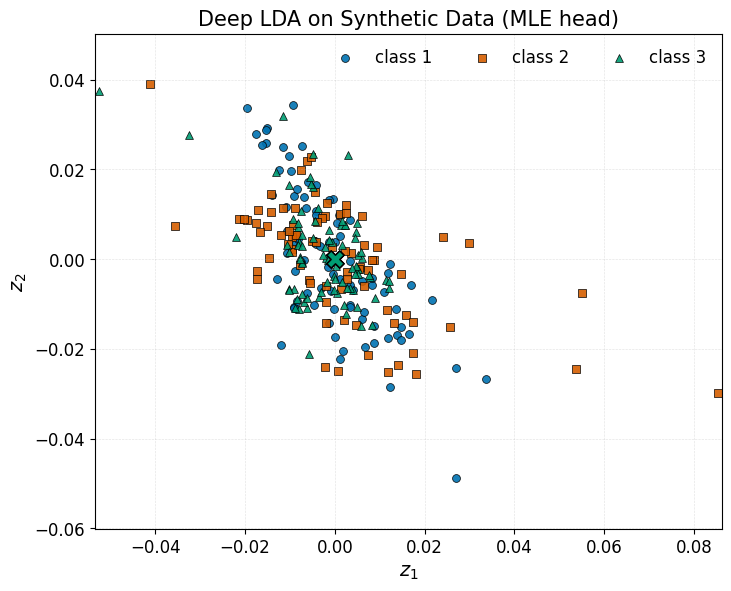

In [9]:
from matplotlib.patches import Ellipse

OKABE_ITO = ["#0072B2", "#D55E00", "#009E73", "#CC79A7", "#56B4E9",
             "#E69F00", "#F0E442", "#000000", "#999999", "#E66100"]
markers = ["o", "s", "^", "v", "D", "P", "X", "*", "h", ">"]

class_means = mu if mu.dim() == 2 else mu.mean(dim=1)
centers = class_means.numpy()
color_cycle = (OKABE_ITO * ((centers.shape[0] // len(OKABE_ITO)) + 1))[:centers.shape[0]]

# with torch.no_grad():
#     L = model.head._chol_factor().detach().cpu().numpy()
# Sigma = L @ L.T

# def cov_ellipse(mean, cov, k=2.15, **kwargs):
#     vals, vecs = np.linalg.eigh(cov)
#     order = vals.argsort()[::-1]
#     vals, vecs = vals[order], vecs[:, order]
#     width, height = 2 * k * np.sqrt(np.maximum(vals, 1e-12))
#     angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
#     return Ellipse(xy=mean, width=width, height=height, angle=angle, **kwargs)

plt.rcParams.update({
    "font.size": 13,
    "axes.labelsize": 14,
    "axes.titlesize": 15,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})
fig, ax = plt.subplots(figsize=(7.2, 5.8), constrained_layout=True)

for c in range(centers.shape[0]):
    idx = (Y == c)
    marker = markers[c % len(markers)]
    ax.scatter(Z[idx, 0], Z[idx, 1], s=32, c=color_cycle[c], marker=marker,
               edgecolors="black", linewidths=0.55, alpha=0.9, label=f"class {c+1}")
    m = centers[c]
    ax.scatter(m[0], m[1], s=150, marker="X", c=color_cycle[c],
               edgecolors="black", linewidths=1.0, zorder=5)
    #ellipse = cov_ellipse(m, Sigma, k=2.15, edgecolor="black",
    #                      facecolor="none", lw=1.1, linestyle="--", alpha=0.85)
    #ax.add_patch(ellipse)

ax.set_title("Deep LDA on Synthetic Data (MLE head)")
ax.set_xlabel(r"$z_1$")
ax.set_ylabel(r"$z_2$")
ax.axis("equal")
pad = 0.0
xmin, xmax = Z[:, 0].min() - pad, Z[:, 0].max() + pad
ymin, ymax = Z[:, 1].min() - pad, Z[:, 1].max() + pad
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.legend(frameon=False, loc="upper right", ncol=min(3, centers.shape[0]))
ax.grid(True, linewidth=0.45, alpha=0.35, linestyle="--")
plt.show()

